In [35]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pylab as plt

import DDPG
import torch

## Helper Functions

In [36]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)    

In [37]:
def run(env, agent, n_episodes=100, noise=0):
    rewards = []
    observations = []
    actions = []
    for ep in range(1, n_episodes+1):
        ep_reward = 0
        state, _info = env.reset()
        for t in range(2000):
            action = agent.act(state, noise)
            state, reward, done, _trunc, _info = env.step(action)
            observations.append(state)
            actions.append(action)
            ep_reward += reward
            if done or _trunc:
                break
        rewards.append(ep_reward)
        ep_reward = 0
    print(f'Mean reward: {np.mean(rewards)}')
    observations = np.asarray(observations)
    actions = np.asarray(actions)
    return observations, actions, rewards

# DDPG

In [38]:
env_name = "Pendulum-v1"

eps=0.1
ts=32
lr=0.0001
s=1

with open(f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr}-s{s}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    losses =  np.asarray(data["losses"])

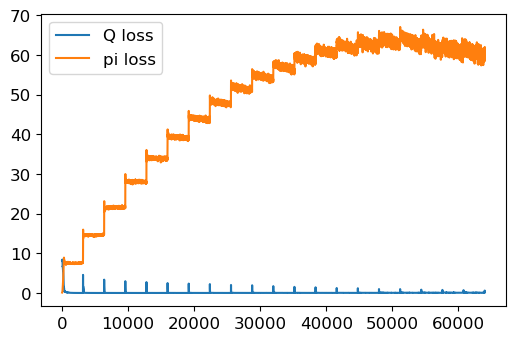

In [39]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(losses[:,0],10),label=f"Q loss")
plt.plot(running_mean(losses[:,1],10),label=f"pi loss")
plt.legend()

TODO: Plot the rewards and the dependency on the hyperparameters

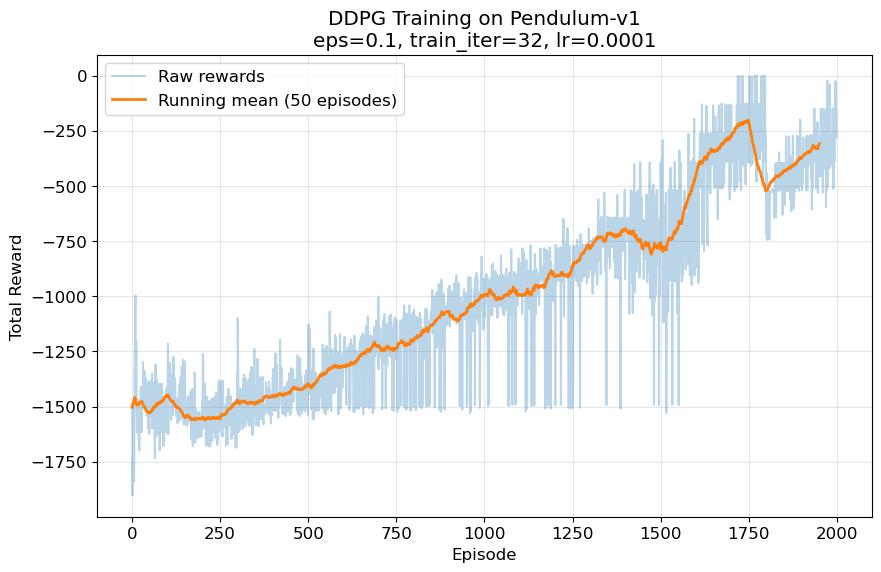

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(rewards, alpha=0.3, label='Raw rewards')
ax.plot(running_mean(rewards, 50), linewidth=2, label='Running mean (50 episodes)')
ax.set_xlabel('Episode')
ax.set_ylabel('Total Reward')
ax.set_title(f'DDPG Training on {env_name}\neps={eps}, train_iter={ts}, lr={lr}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

File not found for lr=0.0005
File not found for lr=5e-05


/var/folders/8d/3z39z6ts1_7c4jm45zycj_2c0000gn/T/ipykernel_6383/3304613853.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


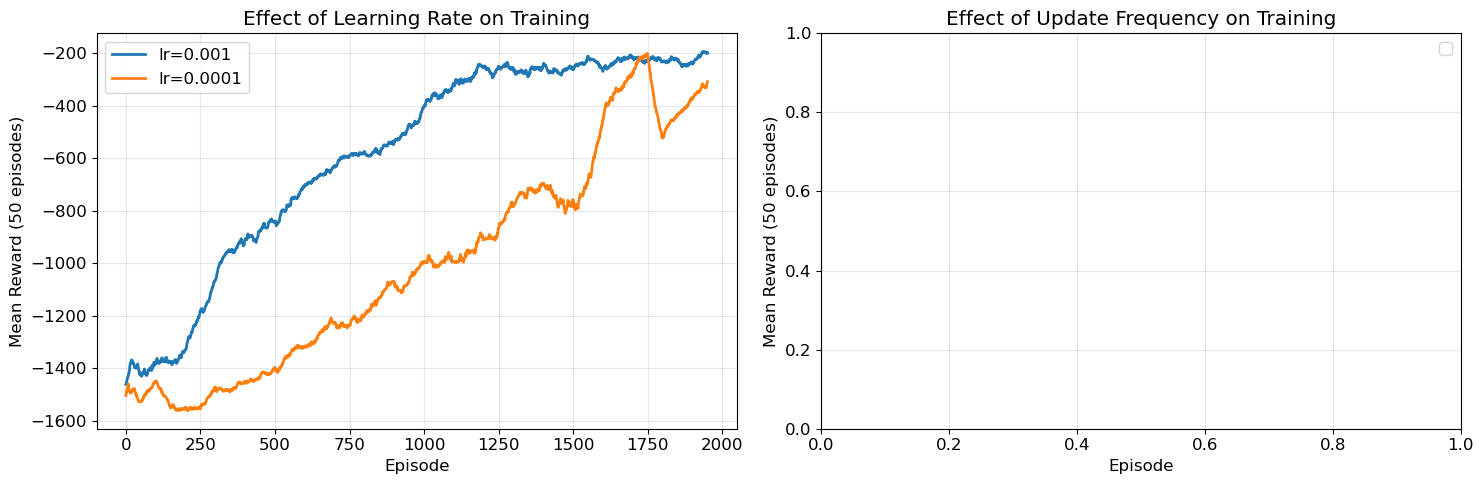

In [ ]:
learning_rates = [0.001, 0.0005, 0.0001, 0.00005]
update_frequencies = [20, 100]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Different learning rates with update_freq=20
update_freq_test = 20
for lr_test in learning_rates:
    try:
        with open(f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr_test}-s{s}-u{update_freq_test}-stat.pkl", 'rb') as f:
            data = pickle.load(f)
            rewards_test = np.asarray(data["rewards"])
            axes[0].plot(running_mean(rewards_test, 50), label=f'lr={lr_test}', linewidth=2)
    except FileNotFoundError:
        print(f"File not found for lr={lr_test}, update={update_freq_test}")

axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Mean Reward (50 episodes)')
axes[0].set_title(f'Effect of Learning Rate (update_freq={update_freq_test})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Different update frequencies with fixed lr
lr_fixed = 0.0001  # Use the best performing learning rate
for update_freq in update_frequencies:
    try:
        with open(f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr_fixed}-s{s}-u{update_freq}-stat.pkl", 'rb') as f:
            data = pickle.load(f)
            rewards_test = np.asarray(data["rewards"])
            axes[1].plot(running_mean(rewards_test, 50), label=f'update={update_freq}', linewidth=2)
    except FileNotFoundError:
        print(f"File not found for lr={lr_fixed}, update={update_freq}")

axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Mean Reward (50 episodes)')
axes[1].set_title(f'Effect of Update Frequency (lr={lr_fixed})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## value function

In [8]:
def plot_Q_function(q_function, observations, actions, plot_dim1=0, plot_dim2=2,
                    label_dim1="cos(angle)", label_dim2="angular velocity"):
    plt.rcParams.update({'font.size': 12})
    values =q_function.predict(np.hstack([observations,actions]))
    
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot()
    surf = ax.scatter (observations[:,plot_dim1], observations[:,plot_dim2],  c = values, cmap=cm.coolwarm)
    ax.set_xlabel(label_dim1)
    ax.set_ylabel(label_dim2)

    return fig

In [9]:
env = gym.make(env_name)

In [10]:
episodes=2000
eps=0.1
ts=32
lr=0.0001
checkpoint = f"./results/DDPG_{env_name}_{episodes}-eps{eps}-t{ts}-l{lr}-s1.pth"

TODO: 

Initialize the DDPGAgent and load the checkpoint 

run 100 runs with noise 0.2 (see run function)

use the helper function above to plot the Q function

In [11]:
agent = DDPG.DDPGAgent(
    env.observation_space, 
    env.action_space, 
    eps=eps, 
    learning_rate_actor=lr,
    update_target_every=100
)

# Load the trained checkpoint
state = torch.load(checkpoint)
agent.restore_state(state)
print(f"Loaded checkpoint from {checkpoint}")

Loaded checkpoint from ./results/DDPG_Pendulum-v1_2000-eps0.1-t32-l0.0001-s1.pth


/var/folders/8d/3z39z6ts1_7c4jm45zycj_2c0000gn/T/ipykernel_6383/1852055212.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(checkpoint)


In [12]:
# Run 100 episodes with noise 0.2
observations, actions, episode_rewards = run(env, agent, n_episodes=100, noise=0.2)
print(f"Collected {len(observations)} state-action pairs")
print(f"Mean episode reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")

Mean reward: -357.49292451634
Collected 20000 state-action pairs
Mean episode reward: -357.49 ± 160.73


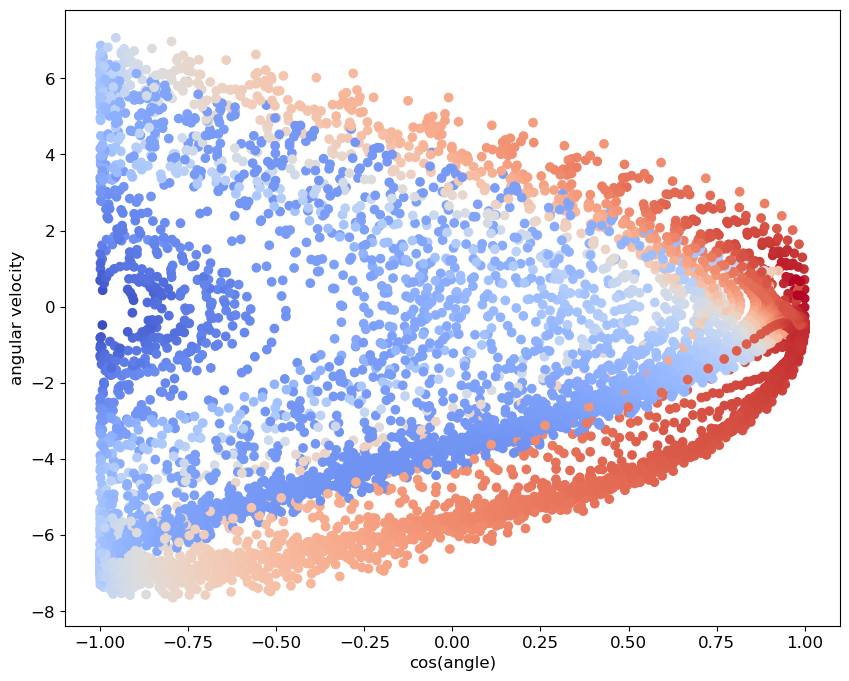

In [13]:
fig = plot_Q_function(
    agent.Q, 
    observations, 
    actions, 
    plot_dim1=0,  
    plot_dim2=2,  
    label_dim1="cos(angle)",
    label_dim2="angular velocity"
)
plt.show()

Bonus: Have we done the right thing? We run the policy with noise to see different states. Are the Q-values actually correct? Can you fix it?

## HalfCheetah

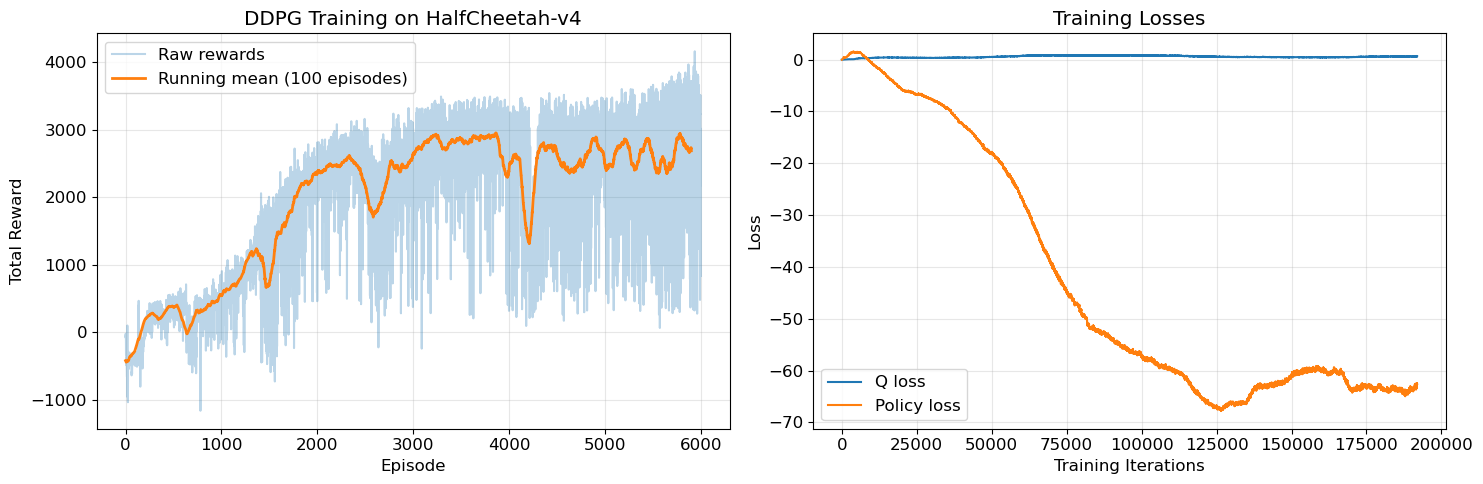

In [31]:
env_name_cheetah = "HalfCheetah-v4"
eps_cheetah = 0.15
ts_cheetah = 32
lr_cheetah = 0.0001
s_cheetah = 2

try:
    with open(f"./results/DDPG_{env_name_cheetah}-eps{eps_cheetah}-t{ts_cheetah}-l{lr_cheetah}-s{s_cheetah}-stat.pkl", 'rb') as f:
        data_cheetah = pickle.load(f)
        rewards_cheetah = np.asarray(data_cheetah["rewards"])
        losses_cheetah = np.asarray(data_cheetah["losses"])
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(rewards_cheetah, alpha=0.3, label='Raw rewards')
    axes[0].plot(running_mean(rewards_cheetah, 100), linewidth=2, label='Running mean (100 episodes)')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Total Reward')
    axes[0].set_title(f'DDPG Training on {env_name_cheetah}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(running_mean(losses_cheetah[:,0], 100), label='Q loss')
    axes[1].plot(running_mean(losses_cheetah[:,1], 100), label='Policy loss')
    axes[1].set_xlabel('Training Iterations')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Training Losses')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print(f"HalfCheetah results not found. Train the model first.")

In [32]:
try:
    env_cheetah = gym.make(env_name_cheetah, render_mode="human")
    
    # Load the trained agent
    agent_cheetah = DDPG.DDPGAgent(
        env_cheetah.observation_space,
        env_cheetah.action_space,
        eps=eps_cheetah,
        learning_rate_actor=lr_cheetah
    )
    
    checkpoint_cheetah = f"./results/DDPG_{env_name_cheetah}_6000-eps{eps_cheetah}-t{ts_cheetah}-l{lr_cheetah}-s{s_cheetah}.pth"
    state_cheetah = torch.load(checkpoint_cheetah)
    agent_cheetah.restore_state(state_cheetah)
    
    # Run a few episodes with rendering
    for episode in range(5):
        obs, _ = env_cheetah.reset()
        episode_reward = 0
        
        for step in range(1000):
            action = agent_cheetah.act(obs, eps=0)  # No exploration noise
            obs, reward, done, trunc, _ = env_cheetah.step(action)
            episode_reward += reward
            
            if done or trunc:
                break
        
        print(f"Episode {episode + 1}: Reward = {episode_reward:.2f}")
    
    env_cheetah.close()
    
except Exception as e:
    print(f"Error visualizing HalfCheetah: {e}")

/var/folders/8d/3z39z6ts1_7c4jm45zycj_2c0000gn/T/ipykernel_6383/4290411286.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_cheetah = torch.load(checkpoint_cheetah

Episode 1: Reward = 4193.99
Episode 2: Reward = 4134.30
Episode 3: Reward = 287.46
Episode 4: Reward = 4011.63
Episode 5: Reward = 4255.61


In [33]:
print("DDPG Training Summary")
print(f"\nPendulum-v1:")
print(f"  Final 100 episodes mean reward: {np.mean(rewards[-100:]):.2f} ± {np.std(rewards[-100:]):.2f}")
print(f"  Best episode reward: {np.max(rewards):.2f}")
print(f"  Total episodes: {len(rewards)}")

try:
    print(f"\nHalfCheetah-v4:")
    print(f"  Final 100 episodes mean reward: {np.mean(rewards_cheetah[-100:]):.2f} ± {np.std(rewards_cheetah[-100:]):.2f}")
    print(f"  Best episode reward: {np.max(rewards_cheetah):.2f}")
    print(f"  Total episodes: {len(rewards_cheetah)}")
except:
    print(f"\nHalfCheetah-v4: Not trained yet")


DDPG Training Summary

Pendulum-v1:
  Final 100 episodes mean reward: -341.39 ± 123.42
  Best episode reward: -0.76
  Total episodes: 2000

HalfCheetah-v4:
  Final 100 episodes mean reward: 2688.78 ± 960.17
  Best episode reward: 4162.35
  Total episodes: 6000
